# Final Project - CNN

**Course**: ANLY590

**Group Members**: Yuan Liu, Guiming Xu, Kuiyu Zhu, Yuxuan Yao

**NetID**: yl1130,gx26, kz175, yy560

**Dataset**: https://www.kaggle.com/cse0031/speech-representation-and-data-exploration

The dataset contains information files and a folder of audio files. The labels that we need to predict in tests are Yes, No, Up, Down, Left, Right, On, Off, Stop, Go, and everything else should be considered either unknown or silent.

This notebook is for the CNN training and simple prediction and recognition of audio files.

### Import Packages

In [3]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot 
import random
import soundfile as sf

### View Data

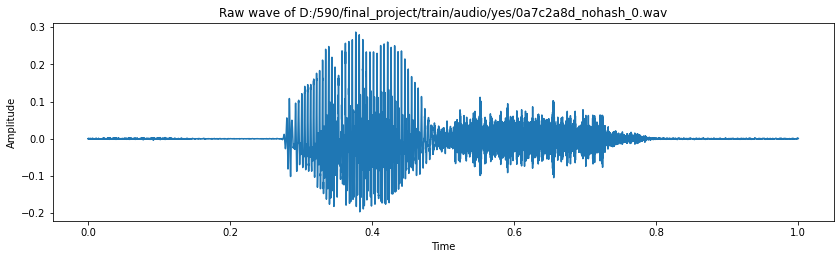

In [4]:
train_audio_path = 'D:/590/final_project/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + 'D:/590/final_project/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [5]:
samples

array([ 0.00042725, -0.00021362, -0.00042725, ...,  0.00057983,
        0.00061035,  0.00082397], dtype=float32)

In [6]:
sample_rate

16000

In [8]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


As we can see, the audio file is transforming to a 1D array. And the rate of sample is 16000.

In that case, we think about downsampling, which can reduce computing time.

In [9]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Listening to the audio file, we can hear "yes" clearly.

**Due to github's restrictions on dataset size, it is not possible to upload our dataset. So this audio cannot be displayed here.**

### View Labels

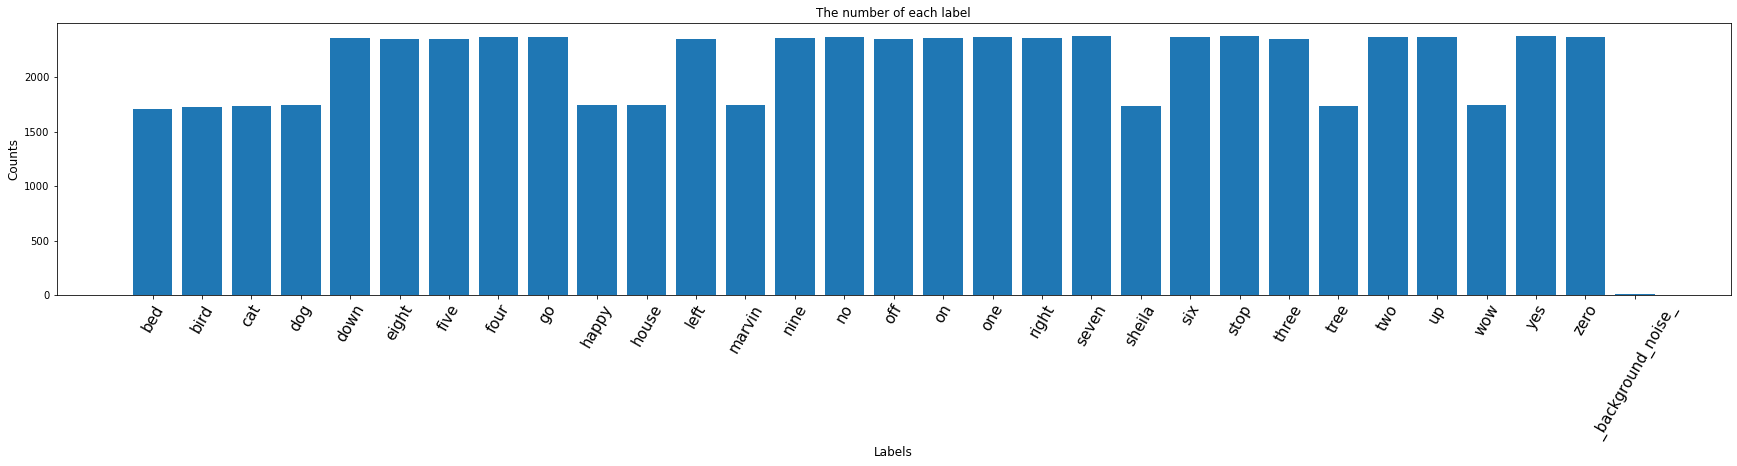

In [12]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
temp=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    temp.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, temp)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('The number of each label')
plt.show()
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "wow", "house", "happy", "tree", "dog", "cat", "bird", 
        "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

In data processing part, we know that most audio files are 1 second duration time and we plot them.

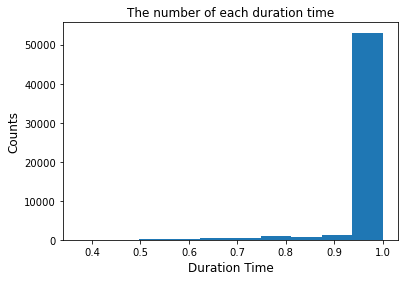

In [14]:
temp=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        temp.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(temp))
plt.xlabel('Duration Time', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('The number of each duration time')
plt.show()

Before modeling, we should downsample all audio files.

In [15]:
train_audio_path = 'D:/590/final_project/train/audio/'
audios = []
allLabel = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            audios.append(samples)
            allLabel.append(label)

yes
no
up
down
left
right
on
off
stop
go
wow
house
happy
tree
dog
cat
bird
one
two
three
four
five
six
seven
eight
nine


Encoder labels

In [20]:
le = LabelEncoder()
y=le.fit_transform(allLabel)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
audios = np.array(audios).reshape(-1,8000,1)

### Modeling

Split train and test sets

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(np.array(audios),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

CNN model

In [23]:
K.clear_session()
inputs = Input(shape=(8000,1))

# The input are 1D arrays because we audio files into arrays, and we use Conv1D and MaxPooling1D
#First Conv1D layer
x = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Second Conv1D layer
x = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Third Conv1D layer
x = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

#Fourth Conv1D layer
x = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(x)
x = MaxPooling1D(3)(x)
x = Dropout(0.3)(x)

# Convert 1D arrays to a single long continuous linear vector
#Flatten layer
x = Flatten()(x)

# Connect to entire neural network
#Dense Layer 1
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

#Dense Layer 2
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(len(labels), activation='softmax')(x)

CNN_model = Model(inputs, outputs)
CNN_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

### Train CNN_model

In [24]:
CNN_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = CNN_model.fit(x_train, y_train ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
1286/1286 [==============================] - 97s 75ms/step - loss: 2.7977 - accuracy: 0.1300 - val_loss: 2.3675 - val_accuracy: 0.2654
Epoch 2/100
1286/1286 [==============================] - 98s 76ms/step - loss: 2.0435 - accuracy: 0.3454 - val_loss: 1.5927 - val_accuracy: 0.5066
Epoch 3/100
1286/1286 [==============================] - 98s 76ms/step - loss: 1.5768 - accuracy: 0.5019 - val_loss: 1.2850 - val_accuracy: 0.6055
Epoch 4/100
1286/1286 [==============================] - 97s 76ms/step - loss: 1.3405 - accuracy: 0.5810 - val_loss: 1.0828 - val_accuracy: 0.6793
Epoch 5/100
1286/1286 [==============================] - 98s 76ms/step - loss: 1.1950 - accuracy: 0.6259 - val_loss: 1.0019 - val_accuracy: 0.6978
Epoch 6/100
1286/1286 [==============================] - 98s 76ms/step - loss: 1.1002 - accuracy: 0.6574 - val_loss: 0.9243 - val_accuracy: 0.7215
Epoch 7/100
1286/1286 [==============================] - 98s 76ms/step - loss: 1.0256 - accuracy: 0.6835 - val_loss: 0

1286/1286 [==============================] - 95s 74ms/step - loss: 0.6357 - accuracy: 0.8035 - val_loss: 0.6268 - val_accuracy: 0.8089
Epoch 28/100
1286/1286 [==============================] - 96s 74ms/step - loss: 0.6147 - accuracy: 0.8081 - val_loss: 0.6029 - val_accuracy: 0.8177
Epoch 29/100
1286/1286 [==============================] - 96s 74ms/step - loss: 0.6133 - accuracy: 0.8097 - val_loss: 0.6123 - val_accuracy: 0.8120
Epoch 30/100
1286/1286 [==============================] - 96s 74ms/step - loss: 0.6052 - accuracy: 0.8135 - val_loss: 0.5469 - val_accuracy: 0.8353
Epoch 31/100
1286/1286 [==============================] - 96s 74ms/step - loss: 0.5843 - accuracy: 0.8188 - val_loss: 0.5707 - val_accuracy: 0.8285
Epoch 32/100
1286/1286 [==============================] - 95s 74ms/step - loss: 0.5968 - accuracy: 0.8173 - val_loss: 0.6088 - val_accuracy: 0.8156
Epoch 33/100
1286/1286 [==============================] - 95s 74ms/step - loss: 0.5798 - accuracy: 0.8200 - val_loss: 0.5607 

### Results

In [31]:
score = CNN_model.evaluate(x_val, y_val, verbose=1)
print("The test accuracy: {acc}".format(acc = score[1]))

322/322 [==============================] - 5s 15ms/step - loss: 0.5705 - accuracy: 0.8266
The test accuracy: 0.8265901803970337


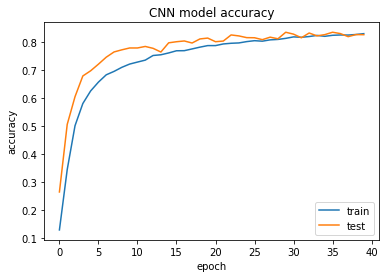

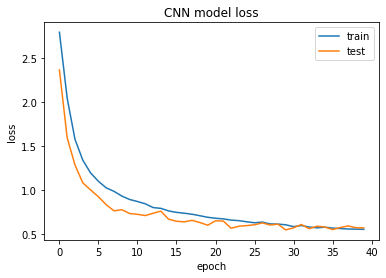

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='bottom right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

The train loss and test loss are both decreasing, which means the model is still learning and it is the best model.

### Simple Recognition

In [39]:
def predict(audio):
    prob=CNN_model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Randomly select 10 audio files from dataset and recognize them:

In [48]:
index=[]
samples=[]
for i in range(10):
    print("No.",i+1,":")
    index.append(random.randint(0,len(x_val)-1))
    samples.append(x_val[index[i]].ravel())
    print("Original Audio:",classes[np.argmax(y_val[index[i]])])
    ipd.Audio(samples, rate=8000)
    print("Recgnition Text:",predict(samples[i]))
    if(classes[np.argmax(y_val[index[i]])]==predict(samples[i])):
        print("Recognition Success")
    else:
        print("Recognition Failed")
    print("--------------")

No. 1 :
Original Audio: no
Recgnition Text: no
Recognition Success
--------------
No. 2 :
Original Audio: no
Recgnition Text: no
Recognition Success
--------------
No. 3 :
Original Audio: two
Recgnition Text: two
Recognition Success
--------------
No. 4 :
Original Audio: go
Recgnition Text: go
Recognition Success
--------------
No. 5 :
Original Audio: bird
Recgnition Text: three
Recognition Failed
--------------
No. 6 :
Original Audio: six
Recgnition Text: six
Recognition Success
--------------
No. 7 :
Original Audio: left
Recgnition Text: left
Recognition Success
--------------
No. 8 :
Original Audio: nine
Recgnition Text: nine
Recognition Success
--------------
No. 9 :
Original Audio: no
Recgnition Text: go
Recognition Failed
--------------
No. 10 :
Original Audio: eight
Recgnition Text: eight
Recognition Success
--------------


As we can see, most of the recognitions are correct but No.5 and No.9 are failed. In general, it is close to 80%, which is the model accuracy.

Listen and prediton.

In [49]:
os.listdir('D:/590/final_project/train/audio/right')
filepath='D:/590/final_project/train/audio/right'
samples, sample_rate = librosa.load(filepath + '/' + '4c7c95de_nohash_1.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [50]:
predict(samples)

'right'

In [51]:
os.listdir('D:/590/final_project/train/audio/happy')
filepath='D:/590/final_project/train/audio/happy'
samples, sample_rate = librosa.load(filepath + '/' + '0c5027de_nohash_1.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [52]:
predict(samples)

'happy'

In [53]:
os.listdir('D:/590/final_project/train/audio/stop')
filepath='D:/590/final_project/train/audio/stop'
samples, sample_rate = librosa.load(filepath + '/' + '0c40e715_nohash_1.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [54]:
predict(samples)

'stop'

Generally, our CNN model could do some simple speech recognition now, and the accuracy is around 82%.

**Due to github's restrictions on dataset size, it is not possible to upload our dataset. So Out[49], Out[51] and Out[53] audios cannot be displayed here.**